# Determining Climbing Route Styles of Mountain Project Sport Routes
#### Clara McIntyre and Andres Rivas

Mountain Project is essentially an online guidebook that contains information about rock climbing routes all over the world. It allows climbers to look at routes by location, difficulty, and/or star rating to determine what they are interested in climbing. ![Mountain Project Home Screen](Mountain_proj_home.png)

For each route on Mountain Project there is a bunch of associated helpful information, such as the rating of the route, it's location, the difficulty, and most importantly, a text description. The Kaggle Dataset we use https://www.kaggle.com/datasets/pdegner/mountain-project-rotues-and-forums?resource=download contains 116,700 of such routes from Mountain project, with their associated metadata. We are particularly interested in the text descriptions. They commonly talk about what it is like to climb the route, the type of gear needed to climb it, and also they style of climbing involved in the route. Climbing style is essentially what it is like to climb the route. Style is important because each climber tends to have a type of style they prefer, for example someone may really like routes with lots of small holds. Unfortunately, Mountain Project has no simple way to tell the style of routes without going through and reading a bunch of descriptions. Therefore, we want to see if topic models can be leveraged to determine the climbing styles involved in routes. We specifically want to focus on sport routes as opposed to trad or alpine routes because sport routes tend to have a diverse range of style. ![Mountain Project Route](Just_Do_It.png)

## Data Pre-Processing

To begin this process, we need to clean up our data and get it into a workable form for our topic model. To make this process easier we will be keeping our data in a Pandas dataframe. Our cleaning steps include removing unnecessary data columns, removing non sport routes, removing routes with no descriptions or overly long descriptions, and making sure we only include routes with English descriptions. With this cleaning process we go from having 116,700 routes in our dataset to 62,544 routes.

### Read in the Mountain Project csv into pandas dataframe

We start by reading in the Mountain Project data CSV from the Kaggle dataset into a dataframe. We can look at the column names to ensure our data was read in properly and gain an understanding of what type of data we have access to.

In [48]:
from collections import Counter

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns

In [49]:
# Importing modules
import pandas as pd

file_path = "dataset/mp_routes.csv"

# Read data into papers
df = pd.read_csv(file_path)

# Print head
df.head()

,Unnamed: 0,Route,Location,URL,Avg Stars,Route Type,Rating,Pitches,Length,Area Latitude,Area Longitude,desc,protection,num_votes
0,0,Access Denied,El Mirador > El Potrero Chico > Nuevo Leon > N...,https://www.mountainproject.com/route/11014983...,2.9,Sport,5.10b/c,4,350.0,25.95044,-100.47755,This is a really great route~ with awesome exp...,12 draws + 60m Rope Take 22 draws if you wan...,22
1,1,Agave Nectar,Sugar Shack > Cougar Canyon (Creek) - CONSTRUC...,https://www.mountainproject.com/route/11091386...,2.0,Sport,5.10b/c,1,NaN,51.09642,-115.31767,from tabvar: Cool fins to roof~ thin holds...,4 bolts to anchor,1
2,2,Ant & Bee do Yoga,The Hen House > Kamloops > British Columbia > ...,https://www.mountainproject.com/route/11240652...,2.7,Trad,5.10b/c,1,NaN,50.57212,-120.13874,A safe mixed route with a bit of run out up to...,"mixed~ gear to 4""",3
3,3,Besame Fuerte,Pilon De Lolita > Loreto Area > Baja Californi...,https://www.mountainproject.com/route/11608640...,2.0,Sport,5.10b/c,1,80.0,26.01097,-111.34166,Start on a slab under a left leaning arched ro...,bolts,1
4,4,Big Momma's Rock,The Courtyard > Mamquam FSR > Squamish > Briti...,https://www.mountainproject.com/route/11445772...,3.0,Sport,5.10b/c,1,60.0,49.71393,-123.09943,Fun technical climbing. Tricky right off the bat.,bolts,3


In [50]:
# Print the column names
print(df.columns)

# Print number of rows
print("Number of routes:", len(df))

Index(['Unnamed: 0', 'Route', 'Location', 'URL', 'Avg Stars', 'Route Type',
       'Rating', 'Pitches', 'Length', 'Area Latitude', 'Area Longitude',
       ' desc', ' protection', ' num_votes'],
      dtype='object')
Number of routes: 116700


### Dropping Unwanted Data Columns

There are a number of columns in the data that are not interesting to us and probably won't be interesting in future exploration, so we can go ahead and remove those columns. These columns include things like 'Area Latitude' and 'protection' that probably do not play any significant role in climbing styles.

In [51]:
# Remove the columns
df = df.drop(columns=['Unnamed: 0', 'URL', 'Pitches', 'Length', 'Area Latitude', 'Area Longitude', ' protection', ' num_votes'], axis=1)

# Print out the first rows of papers
df.head()

,Route,Location,Avg Stars,Route Type,Rating,desc
0,Access Denied,El Mirador > El Potrero Chico > Nuevo Leon > N...,2.9,Sport,5.10b/c,This is a really great route~ with awesome exp...
1,Agave Nectar,Sugar Shack > Cougar Canyon (Creek) - CONSTRUC...,2.0,Sport,5.10b/c,from tabvar: Cool fins to roof~ thin holds...
2,Ant & Bee do Yoga,The Hen House > Kamloops > British Columbia > ...,2.7,Trad,5.10b/c,A safe mixed route with a bit of run out up to...
3,Besame Fuerte,Pilon De Lolita > Loreto Area > Baja Californi...,2.0,Sport,5.10b/c,Start on a slab under a left leaning arched ro...
4,Big Momma's Rock,The Courtyard > Mamquam FSR > Squamish > Briti...,3.0,Sport,5.10b/c,Fun technical climbing. Tricky right off the bat.


In [52]:
print(df.columns)

Index(['Route', 'Location', 'Avg Stars', 'Route Type', 'Rating', ' desc'], dtype='object')


### Remove all non sport or top rope routes
Let's also remove all non sport or top rope (TR) routes. We decide to focus on sport climbs and top ropes because trad routes or alpine most commonly have a crack style or non rock specific style which then makes it difficult for the topic model to find clear categories with other style types. Thus, by removing these types of routes we can get a more diverse set of styles in our topic modeling. Doing so cuts down the number of routes in our dataset from 116,700 to 65,298.

In [53]:
# Print the number of rows before removal
print("Number of rows before removal:", len(df))

# Get unique values from the route type
unique_values = df['Route Type'].unique()
print(unique_values)

# routes that are not TR or Sport
df = df[(df['Route Type'] == 'Sport') | (df['Route Type'] == 'TR') | (df['Route Type'] == 'Sport, TR') | (df['Route Type'] == 'Sport, TR, Boulder')]

# Print the number of rows before removal
print("Number of rows after removal:", len(df))

Number of rows before removal: 116700
['Sport' 'Trad' 'Trad, Alpine' 'Sport, TR' 'Sport, Alpine' 'Trad, Sport'
 'Trad, TR' 'Sport, Aid' 'Trad, Aid' 'Trad, Aid, Alpine'
 'Trad, TR, Alpine' 'Trad, Snow, Alpine' 'Trad, Sport, TR' 'Trad, Boulder'
 'Sport, TR, Alpine' 'Trad, TR, Boulder' 'Trad, Ice' 'Trad, Snow'
 'Trad, Ice, Alpine' 'Trad, Ice, Snow, Alpine' 'Trad, Mixed, Alpine'
 'Trad, Mixed, Ice, Alpine' 'Trad, Mixed, Ice, Snow, Alpine'
 'Trad, Ice, Snow' 'Trad, Mixed, Snow, Alpine' 'Sport, Boulder'
 'Trad, Sport, Alpine' 'Trad, TR, Aid' 'Trad, Mixed, Ice' 'Trad, Mixed'
 'Trad, Sport, Aid' 'Sport, Aid, Alpine' 'Trad, Aid, Snow, Alpine'
 'Sport, Mixed, Ice' 'Trad, TR, Mixed, Ice' 'Sport, Mixed'
 'Trad, Aid, Boulder' 'Sport, Snow' 'Sport, TR, Aid'
 'Sport, Aid, Boulder, Mixed, Ice, Snow' 'Trad, Aid, Ice, Alpine'
 'Sport, TR, Boulder' 'Sport, TR, Aid, Boulder' 'Trad, Sport, TR, Alpine'
 'Trad, Mixed, Ice, Snow' 'Trad, Sport, Aid, Boulder, Ice, Snow'
 'Trad, Aid, Boulder, Alpine' 'Trad, Boul

In [46]:
df.head()

,Route,Location,Avg Stars,Route Type,Rating,desc
0,Access Denied,El Mirador > El Potrero Chico > Nuevo Leon > N...,2.9,Sport,5.10b/c,This is a really great route~ with awesome exp...
1,Agave Nectar,Sugar Shack > Cougar Canyon (Creek) - CONSTRUC...,2.0,Sport,5.10b/c,from tabvar: Cool fins to roof~ thin holds...
2,Ant & Bee do Yoga,The Hen House > Kamloops > British Columbia > ...,2.7,Trad,5.10b/c,A safe mixed route with a bit of run out up to...
3,Besame Fuerte,Pilon De Lolita > Loreto Area > Baja Californi...,2.0,Sport,5.10b/c,Start on a slab under a left leaning arched ro...
4,Big Momma's Rock,The Courtyard > Mamquam FSR > Squamish > Briti...,3.0,Sport,5.10b/c,Fun technical climbing. Tricky right off the bat.


### Remove any routes with overly long or short descriptions

Let's now make sure we don't include any routes in our cleaned data with overly long text descriptions or no description at all. To do this, let's start by looking at some statistics about the lengths of our route descriptions and plotting them using a histogram.

Number of rows before removal: 65298
Statistics of Route Description Lengths:
Number of Descriptions: 65103
Total Words in Descriptions: 279616.08
Mean Length: 257.70 words
Standard Deviation: 283.83 words
Minimum Length: 1.00 words
Maximum Length: 9525.00 words


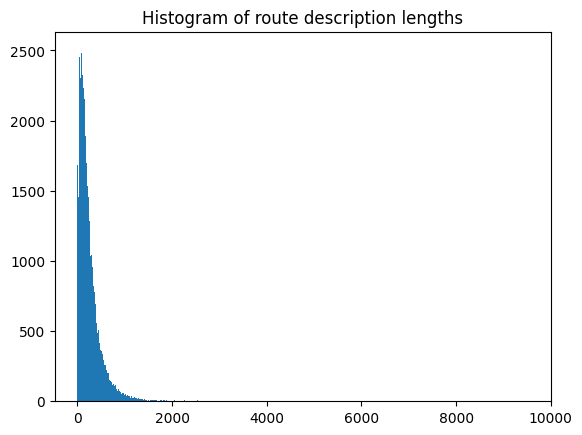

In [54]:
import matplotlib.pyplot as plt

# Print the number of rows before removal
print("Number of rows before removal:", len(df))

# remove rows with no description
df = df[(df[' desc'].str.split().str.len() > 0)]

# Iterate through each description in the 'desc' column and create a list of lengths
description_lengths = [len(desc) for desc in df[' desc']]

# Convert the list to a numpy array for easy calculations
len_desc = np.array(description_lengths)

num_clips = len(len_desc)
total_length = sum(len_desc)
mean_length = np.mean(len_desc)
std_deviation = np.std(len_desc)
min_length = np.min(len_desc)
max_length = np.max(len_desc)

print("Statistics of Route Description Lengths:")
print("============================")
print(f"Number of Descriptions: {num_clips}")
print(f"Total Words in Descriptions: {(total_length / 60):.2f}")
print(f"Mean Length: {mean_length:.2f} words")
print(f"Standard Deviation: {std_deviation:.2f} words")
print(f"Minimum Length: {min_length:.2f} words")
print(f"Maximum Length: {max_length:.2f} words")

_ = plt.hist(len_desc, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of route description lengths")
plt.show()

In [55]:
# Remove rows with descriptions containing more than 2000 words
df = df[(df[' desc'].str.split().str.len() <= 2000)]

# Print the number of rows after removal
print("Number of rows after removal:", len(df))

Number of rows after removal: 65103


In [56]:
df[' desc'].head()

0    This is a really great route~ with awesome exp...
1    from tabvar:     Cool fins to roof~ thin holds...
3    Start on a slab under a left leaning arched ro...
4    Fun technical climbing. Tricky right off the bat.
5    Two potential starts. 1) Travers across canyon...
Name:  desc, dtype: object

### Remove any routes with non-English descriptions
Now that we have gotten rid of any overly long or short descriptions, let's make sure they are all in English using the langdetect library. The routes are from all over the world, so we want to only look at those with English descriptions otherwise it will be really hard for us to label the topics later.

In [57]:
from langdetect import detect

# Function to check if a text is in English using langdetect
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False
    
# Remove rows where the description is not in English
df = df[df[' desc'].apply(is_english)]

# Print the number of rows after removal of non-English
print("Number of rows after removal:", len(df))

Number of rows after removal: 62544


### Remove punctuation and lowercase all descriptions

Now let'a get rid of punctuation so that it does not mess up our topics and lowercase all of our descriptions so that there are fewer unique tokens/words.

In [58]:
import string

# Remove punctuation and convert to lowercase
def clean_text(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    return text.lower()

# Apply text cleaning to the description column
df[' desc'] = df[' desc'].apply(clean_text)

df.head()

,Route,Location,Avg Stars,Route Type,Rating,desc
0,Access Denied,El Mirador > El Potrero Chico > Nuevo Leon > N...,2.9,Sport,5.10b/c,this is a really great route with awesome expo...
1,Agave Nectar,Sugar Shack > Cougar Canyon (Creek) - CONSTRUC...,2.0,Sport,5.10b/c,from tabvar cool fins to roof thin holds o...
3,Besame Fuerte,Pilon De Lolita > Loreto Area > Baja Californi...,2.0,Sport,5.10b/c,start on a slab under a left leaning arched ro...
4,Big Momma's Rock,The Courtyard > Mamquam FSR > Squamish > Briti...,3.0,Sport,5.10b/c,fun technical climbing tricky right off the bat
5,Big Splash,The Dark Pool > Powell River > British Columbi...,3.0,Sport,5.10b/c,two potential starts 1 travers across canyon a...


###  Save cleaned data to csv

Now that we have our cleaned up data let's save it to a CSV so that the cleaning process does not need to be redone every time one wants to rerun the topic model code. After cleaning there are 112,699 climbing routes.

In [59]:
df.to_csv("mp_routes_clean.csv", encoding='utf-8', index=False)

## Topic Modeling!

Now that we have pre-processed the data let's play with it! We will do this using a Tomotopy topic model. The topic model will find different topics within our route descriptions that we can then manually map to different climbing styles. These mappings can then be used to label our different routes with the different styles they fall within.

### Read in cleaned data

In [60]:
# Importing modules
import pandas as pd

file_path = "mp_routes_clean.csv"

# Read data into papers
df = pd.read_csv(file_path)

# Print head
df.head()

,Route,Location,Avg Stars,Route Type,Rating,desc
0,Access Denied,El Mirador > El Potrero Chico > Nuevo Leon > N...,2.9,Sport,5.10b/c,this is a really great route with awesome expo...
1,Agave Nectar,Sugar Shack > Cougar Canyon (Creek) - CONSTRUC...,2.0,Sport,5.10b/c,from tabvar cool fins to roof thin holds o...
2,Besame Fuerte,Pilon De Lolita > Loreto Area > Baja Californi...,2.0,Sport,5.10b/c,start on a slab under a left leaning arched ro...
3,Big Momma's Rock,The Courtyard > Mamquam FSR > Squamish > Briti...,3.0,Sport,5.10b/c,fun technical climbing tricky right off the bat
4,Big Splash,The Dark Pool > Powell River > British Columbi...,3.0,Sport,5.10b/c,two potential starts 1 travers across canyon a...


### Train Topic Model

We train a tomotopy topic model with 30 different topics for 1000 iterations. In addition to the stopwords from nltk.corpus, we will add more of our own that are climbing related but not climbing style related. Doing this will help make each of our topics more climbing style specific and reduce the number of non-style related topics that are generated. After training our model we look at the top 25 words per topic to start to get a sense of what each of our topics are. Then, to further understand our topics we look at the top 5 documents for each topic. By doing both of these things we can narrow down which of our topics are climbing style related and then determine which style they correspond to. Not all of our topics will be style related or correspond to one clear style. However, with those that are, we can create a mapping from the topic to a style label and use that mapping to label our routes with styles.

In [61]:
import tomotopy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cfmci\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Add certain climbing terms that are not route style related to our stoplist

In [62]:
more_stop_words = {"anchor", "bolt", "climb", "belay", "left", "right", "bolts", "climbed", "first", "ascent", "north", "east", "south", "west", 
                   "rap", "route", "pitch", "pro", "cam", "cams", "finish", "crux", "start", "classic", "quality", "excellent", "fun", "climbing", "bolted", 
                   "cruxes", "good", "great", "guide", "guidebook", "description", "book", "routes", "rating", "located", "side", "trail", "cliff", "approach", 
                   "rope", "drag", "top", "rated", "pitches", "ropes", "anchors", "rope", "lower", "bolted", "tree", "trees", "lead", "snow", "follow", "trad",
                   "gear"}

In [63]:
# 30-topic model populated with documents from our reviews (with stopwords removed)
stoplist = set(stopwords.words('english'))
stoplist.update(more_stop_words)

n_topics = 30
n_docs = len(df)

mdl = tomotopy.LDAModel(k=n_topics)
for desc in df[' desc']:
  words = desc.split()
  mdl.add_doc([w for w in words if w not in stoplist and w.isalpha()])

In [64]:
# Most converging will happen fast, but we'll run for 1000 iterations just in case
# (this will take a minute)
iters_per_check = 50
for i in range(0, 1000, iters_per_check):
    mdl.train(iters_per_check)
    print('Iteration: {}\tLog-likelihood: {}'.format(i+iters_per_check, mdl.ll_per_word))

Iteration: 50	Log-likelihood: -8.710402456233307
Iteration: 100	Log-likelihood: -8.522859130893297
Iteration: 150	Log-likelihood: -8.4451444058873
Iteration: 200	Log-likelihood: -8.401185571379184
Iteration: 250	Log-likelihood: -8.373062910383434
Iteration: 300	Log-likelihood: -8.351515732775159
Iteration: 350	Log-likelihood: -8.343315254420258
Iteration: 400	Log-likelihood: -8.329662520337212
Iteration: 450	Log-likelihood: -8.32149439179715
Iteration: 500	Log-likelihood: -8.318536997149122
Iteration: 550	Log-likelihood: -8.313751229276205
Iteration: 600	Log-likelihood: -8.311176370207566
Iteration: 650	Log-likelihood: -8.305661878595881
Iteration: 700	Log-likelihood: -8.307233996611597
Iteration: 750	Log-likelihood: -8.305061267388966
Iteration: 800	Log-likelihood: -8.306919006392839
Iteration: 850	Log-likelihood: -8.305871403914544
Iteration: 900	Log-likelihood: -8.29921849296512
Iteration: 950	Log-likelihood: -8.298412861810633
Iteration: 1000	Log-likelihood: -8.29484238278637


### Top 25 words per topic

In [65]:
# Print top 25 words of each topic
print("Top 25 words by topic")
for k in range(n_topics):
    print('#{}: {}'.format(k, ' '.join([w for (w, prop) in mdl.get_topic_words(k, top_n=25)])))

Top 25 words by topic
#0: moves leads easier easy tricky thin section hard slab move steep technical face bulge sustained short bouldery rest holds second ground interesting powerful gets difficult
#1: line project new years name originally fa one named original done put time added old since sport many recently climbers got used open bolting later
#2: clip second clipping stick fall third ground long last make ledge would high want draw two may feet could use getting runout belayer draws dont
#3: slab pockets rock small holds edges face crimps thin feet angle low moves vertical bulge sharp starts nice features steep section technical bit way near
#4: bit harder grade holds little easier much like one line may hard difficult quite pretty looks moves probably still get though short better rock way
#5: wall face line past climbs main two rock area feet large base three far short end boulder center starts near one crag middle gully steep
#6: rock clean dirty traffic little bit still lichen

### Top 10 docs per topic

In [66]:
# Printing the top 5 documents per topic
for topic_id in range(n_topics):
    print(f"Topic {topic_id + 1}:")
    topic_words = mdl.get_topic_words(topic_id, top_n=25)
    print("Top words:", ', '.join(word for word, prob in topic_words))
    print("Top documents:")
    
    # Enumerate through all documents and calculate the probability of each document belonging to the current topic
    doc_probabilities = [(doc_id, doc.get_topic_dist()[topic_id]) for doc_id, doc in enumerate(mdl.docs)]
    # Sort the documents by their probability for the current topic
    doc_probabilities.sort(key=lambda x: x[1], reverse=True)
    
    # Print top 10 documents
    for doc_id, doc_prob in doc_probabilities[:10]:
        print(f"Document {doc_id}: Probability {doc_prob:.4f} - {df[' desc'][doc_id]}")
    print()

Topic 1:
Top words: moves, leads, easier, easy, tricky, thin, section, hard, slab, move, steep, technical, face, bulge, sustained, short, bouldery, rest, holds, second, ground, interesting, powerful, gets, difficult
Top documents:
Document 37608: Probability 0.8298 - excellent route and great introduction to the crag   quality holds tonthe top with great moves
Document 30453: Probability 0.7835 - neverland 59  95180 f 917b   climb the face left of the large crackchimney to the mid point anchors on the big ledge or all the way to the top  be careful of rope drag on the upper section also be carful apparently there is a snake den right at the base as well as a bunch of poison ivy can also be done as 2 pitches   p1  58  95 f 9b  begin at the edge of the chimney and traverse left over broken rock then climb directly up to the large ledge with the 2 chain anchors   p2  59  85 f 7b  continue up the face above to the high crux and 2 bolt anchors on top best to rappel and not lower from top

In [67]:
# Survey stats
# See https://bab2min.github.io/tomotopy/v0.4.1/en/#tomotopy.LDAModel.infer
mdl.summary()

<Basic Info>
| LDAModel (current version: 0.12.7)
| 62383 docs, 1286080 words
| Total Vocabs: 42724, Used Vocabs: 42724
| Entropy of words: 7.40789
| Entropy of term-weighted words: 7.40789
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 1000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -8.29484
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 30 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 650029957 (random seed)
| trained in version 0.12.7
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.405

## Label Topics Related to Climbing Route Styles
Each route can get multiple labels. If no style can be reasonably associated with a route, label it as unknown.

In [68]:
from collections import Counter

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns

In [69]:
label_to_topics = {"crack": [1,3,12], "slab": [4], "powerful": [5], "roof": [6], "arete/ corner": [7], "dihedral/ flake/ corner": [9], "crimp/ pocket": [13, 15], "sustained": [21]}

In [70]:
# Let's get the topic proportions for each document
doc_topic_props = np.zeros(shape=(n_docs, n_topics))
for i, doc in enumerate(mdl.docs):
    doc_topic_props[i, :] = doc.get_topic_dist()

print(len(mdl.docs))
print(len(doc_topic_props))

62383
62544


#### Assign multiple labels to each route

In [71]:
threshold = 1/(n_topics/2)

In [72]:
# Let's initialize a list to store labels for each document
doc_labels = []

# Iterate through all the documents
for topic_dist in doc_topic_props:
    # Check if any topic appears with more than threshold
    relevant_topics = [topic_idx for topic_idx, proportion in enumerate(topic_dist) if proportion > threshold]
    
    # Initialize an empty list to store labels for this document
    labels_for_doc = []
    
    # Map relevant topics to their labels
    for topic_idx in relevant_topics:
        # Find labels for this topic
        labels_for_topic = [label for label, topics in label_to_topics.items() if topic_idx in topics]
        if labels_for_topic:
            # If labels exist for this topic add them to the list
            labels_for_doc.extend(labels_for_topic)

    # remove duplicate labels
    labels_for_doc = list(set(labels_for_doc))

    # Add "unknown" label only if labels_for_doc is empty
    if not labels_for_doc:
        labels_for_doc.append('unknown')
    
    # Add labels for this document to the list
    doc_labels.append(labels_for_doc)

# Now, add the labels as a new column to your DataFrame
df['labels'] = doc_labels

In [73]:
df.head()

,Route,Location,Avg Stars,Route Type,Rating,desc,labels
0,Access Denied,El Mirador > El Potrero Chico > Nuevo Leon > N...,2.9,Sport,5.10b/c,this is a really great route with awesome expo...,"[arete/ corner, crimp/ pocket]"
1,Agave Nectar,Sugar Shack > Cougar Canyon (Creek) - CONSTRUC...,2.0,Sport,5.10b/c,from tabvar cool fins to roof thin holds o...,[unknown]
2,Besame Fuerte,Pilon De Lolita > Loreto Area > Baja Californi...,2.0,Sport,5.10b/c,start on a slab under a left leaning arched ro...,"[arete/ corner, crimp/ pocket]"
3,Big Momma's Rock,The Courtyard > Mamquam FSR > Squamish > Briti...,3.0,Sport,5.10b/c,fun technical climbing tricky right off the bat,[crack]
4,Big Splash,The Dark Pool > Powell River > British Columbi...,3.0,Sport,5.10b/c,two potential starts 1 travers across canyon a...,"[crimp/ pocket, slab, crack]"


#### Assign only one label to each route

In [74]:
# Let's initialize a list to store labels for each document
doc_labels = []

# Iterate through all the documents
for topic_dist in doc_topic_props:
    relevant_topic = np.where(topic_dist == (max(topic_dist)))[0][0]
    
    # Initialize an empty list to store labels for this document
    labels_for_doc = []
    labels_for_doc = [label for label, topics in label_to_topics.items() if relevant_topic in topics]

    # Add "unknown" label only if labels_for_doc is empty
    if not labels_for_doc:
        labels_for_doc.append('unknown')
    
    # Add labels for this document to the list
    doc_labels.append(labels_for_doc)

# Now, add the labels as a new column to your DataFrame
df['labels'] = doc_labels

In [75]:
df.head()

,Route,Location,Avg Stars,Route Type,Rating,desc,labels
0,Access Denied,El Mirador > El Potrero Chico > Nuevo Leon > N...,2.9,Sport,5.10b/c,this is a really great route with awesome expo...,[crimp/ pocket]
1,Agave Nectar,Sugar Shack > Cougar Canyon (Creek) - CONSTRUC...,2.0,Sport,5.10b/c,from tabvar cool fins to roof thin holds o...,[unknown]
2,Besame Fuerte,Pilon De Lolita > Loreto Area > Baja Californi...,2.0,Sport,5.10b/c,start on a slab under a left leaning arched ro...,[unknown]
3,Big Momma's Rock,The Courtyard > Mamquam FSR > Squamish > Briti...,3.0,Sport,5.10b/c,fun technical climbing tricky right off the bat,[unknown]
4,Big Splash,The Dark Pool > Powell River > British Columbi...,3.0,Sport,5.10b/c,two potential starts 1 travers across canyon a...,[unknown]


#### Random sampling of routes to see how good the labels are

In [76]:
pd.set_option('max_colwidth', None)
df.sample(n=30)

,Route,Location,Avg Stars,Route Type,Rating,desc,labels
11721,The Original Route,Solitude Wall > Solitude Canyon > Mt. Elden Crags > Flagstaff Area > Northern Arizona > Arizona,2.5,Sport,5.11b,this line originally had 3 rotten star drives and homemade hangers dont know if it was freed or aided regardless after leading it and wiggling each piece in its rotten hole i retrobolted it sustained bouldery slab climbing up pretty face to featured crack quality challenge,[slab]
20707,Dancing Bare Naked Ladies,Boundry Crag > Allenspur > Paradise Valley > Southwest Region > Montana,1.7,Sport,5.7,apparently originally done and oft repeated as a free solo straightforward slab and face climbing to a funky lieback move or two at the top climbs of southwest montana gives this a 58 enjoyable if this is your grade but other climbs on the cliff outshine it,[unknown]
29190,Cut for the Chase,The Red Clove Wall > Area 5: Red and White Grotto Walls > Guernsey State Park > Wyoming,2.0,Sport,5.11b,climb left of the prominent outside corner whitish into the overhanging red rock and up to a corner of the dolmite base and past this bulge,[unknown]
1562,Happy Ending,3 Bolt Wonderland > White Mountain > Yukon Territory > Canada > North America > International,3.0,Sport,5.10c/d,challenging feet right off the ground with a low first bolt the holds get progressively bigger and your mind can ease as you head right towards the top,[unknown]
48365,Open Project--Sowerby Roofs.,(7) Jungle Cliff > Broughton Bluff > Portland & The Gorge > Oregon,3.0,Sport,5.14-,i found an unknown bolt line turns out its an abandoned sowerby project it splits off right from slash and burn at around mid height and busts through several tiered roofs i updated the hardware with new stainless asca bolts knocked off some loose blocks left a fixed sling under one of the roofs and chalked up a few holds there is still cleaning to be done on it although it lacks the layer of mud found on the right side of jungle wall as of 11615 i still need to yank out the old bolts and patch the holes some flakes came off of the slash and burn crux as well so the lower portion may now be harder than its original 12a rating from the look of it this route will have several vhard cruxes including a horizontal dyno and possibly a bump to a shallow mono it will make a worthy ascent for whoever gets up the thing have at it,[arete/ corner]
24996,Illustration Arete,EFS Wall > Box Canyon > Maple Canyon Road > Maple Canyon > Utah,1.9,Sport,5.7,climbs the arete right of the water couloir that separates the cobble roof and the efs wall crux is at the last two bolts on a fun vertical section,[unknown]
13862,AMS,The Amphitheater > Upper East Fork (UEF) > Jemez Mountains and Jemez Valley > New Mexico,3.0,Sport,5.11b,named ams acute mountain sickness because a hardcore sport climber claimed he got nose bleeds and headaches from being two pitches up you can avoid ams by doing it in a single pitch and either runnering the midway anchor with a long sling or by clipping the first bolt on the headwall and then unclipping the anchor fun jug haul on steep rock the first half to the midway anchor is mungy 58 but its worth it for the fun climbing above,[unknown]
59391,Fix The Madness,Boy Scout Wall > Bowman Valley > Bowman/Emeralds > I-80 Corridor > Lake Tahoe > California,1.9,Sport,5.10b,looks like it splits left off of ham salad,[unknown]
6141,En el Principio,Genesis > Cerro San Martin > San Carlos de Bariloche > Rio Negro > Argentina > South America > International,3.2,Sport,5.6,this is the first route ever bolted by dylan harris who developed this area hence the name in the beginning for many climbers this is also their first outside rock climb or lead the crux is located near the top,[crack]
23852,Come and Get It,Midway Area > Rainbow Canyon > Southern Nevada > Nevada,2.3,Sport,5.11-,an easy scramble leads to the thin face and arete pull a tough move to the horizontal break and begin working your way up the face using the are

In [77]:
df.to_csv("mp_routes_labeled.csv", encoding='utf-8', index=False)

## Classifier

In [78]:
# Importing modules
import pandas as pd

file_path = "mp_routes_labeled.csv"

# Read data into papers
df = pd.read_csv(file_path)

# Print head
df.head()

,Route,Location,Avg Stars,Route Type,Rating,desc,labels
0,Access Denied,El Mirador > El Potrero Chico > Nuevo Leon > Northern Mexico > Mexico > North America > International,2.9,Sport,5.10b/c,this is a really great route with awesome exposure and a really cool summit it climbs obvious dihedrals and good face climbing up to the ridge p1 510a 11 bolts p2 510a 9 bolts p3 510c 9 bolts crux some cool handjams and good exposure p4 59 8 bolts jugs to the summit you can link pitches and do the route route in two pitches,['crimp/ pocket']
1,Agave Nectar,Sugar Shack > Cougar Canyon (Creek) - CONSTRUCTION IN PROGRESS > Bow Valley > Alberta > Canada > North America > International,2.0,Sport,5.10b/c,from tabvar cool fins to roof thin holds over roof,['unknown']
2,Besame Fuerte,Pilon De Lolita > Loreto Area > Baja California Sur > Mexico > North America > International,2.0,Sport,5.10b/c,start on a slab under a left leaning arched roof follow bolts up and left to the arete at the left hand side of the arching roof turn the roof and follow the bolts on the arete to a two bolt anchor at ledge,['unknown']
3,Big Momma's Rock,The Courtyard > Mamquam FSR > Squamish > British Columbia > Canada > North America > International,3.0,Sport,5.10b/c,fun technical climbing tricky right off the bat,['unknown']
4,Big Splash,The Dark Pool > Powell River > British Columbia > Canada > North America > International,3.0,Sport,5.10b/c,two potential starts 1 travers across canyon and start at the roofdown climb to ledge 2 swim over bring your shoes and chalk and a towel and start on ledge below roof true start starting on this ledge grade unconfirmed cleaned and climbed 3 years ago top may be dirty fairly easy climb but interesting crux to turn the roof climb passed the crux roof then continue slightly right and straight up,['unknown']


In [79]:
from sklearn.feature_extraction.text import CountVectorizer

label_list = []
for label in df["labels"]:
    label_list.append(label[2:-2])
print(label_list)

desc_list = []
for desc in df[" desc"]:
    desc_list.append(desc)
cv = CountVectorizer(min_df=5, max_df=0.6) # words must show up in at least 5 and no more than 60% of documents
features = cv.fit_transform(desc_list)
print(features.shape)
vocab = cv.get_feature_names_out()


['crimp/ pocket', 'unknown', 'unknown', 'unknown', 'unknown', 'slab', 'arete/ corner', 'unknown', 'slab', 'slab', 'slab', 'unknown', 'crack', 'unknown', 'slab', 'slab', 'arete/ corner', 'unknown', 'unknown', 'slab', 'unknown', 'unknown', 'unknown', 'crack', 'sustained', 'arete/ corner', 'crack', 'unknown', 'crimp/ pocket', 'unknown', 'slab', 'crack', 'unknown', 'crack', 'crack', 'crimp/ pocket', 'unknown', 'crack', 'unknown', 'crimp/ pocket', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'crack', 'unknown', 'unknown', 'unknown', 'crimp/ pocket', 'crack', 'unknown', 'unknown', 'crack', 'unknown', 'unknown', 'slab', 'sustained', 'unknown', 'unknown', 'unknown', 'crack', 'unknown', 'unknown', 'unknown', 'slab', 'dihedral/ flake/ corner', 'unknown', 'slab', 'unknown', 'roof', 'crack', 'unknown', 'unknown', 'slab', 'arete/ corner', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'crack', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 

Confusion Matrix
[[   0    8    7    0    1    0    5    0  198]
 [   2  131   26   10    6    4   53    0 1979]
 [   7   29   14    1    5    0   16    0  478]
 [   0   15    5    0    3    0    4    0  162]
 [   2   26    7    0    7    0    8    0  323]
 [   0    5    1    1    0    0    3    0   68]
 [   7   63   25    1    8    0   28    1 1062]
 [   0    3    0    0    1    0    0    0   39]
 [  22  379  102   25   60    8  151    0 6904]]


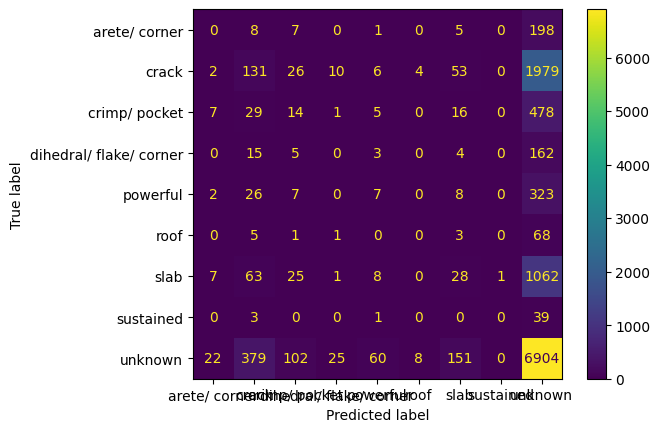

In [80]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

mnb = MultinomialNB()
feat_train, feat_test, label_train, label_test = train_test_split(features, label_list, test_size=0.2)
mnb.fit(feat_train, label_train)
preds = mnb.predict(feat_test)
print("Confusion Matrix")

confusion_matrix = confusion_matrix(label_test, preds)
print(confusion_matrix)
label_names =  ["arete/ corner", "crack", "crimp/ pocket", "dihedral/ flake/ corner", "powerful", "roof", "slab", "sustained", "unknown"]
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels= label_names)

cm_display.plot()
plt.show()

In [81]:
from sklearn.metrics import precision_recall_fscore_support
(precision, recall, f1, support) = precision_recall_fscore_support(label_test, preds)
print("precision scores:", precision)
print("recall scores:", recall)
print("f1 scores:", f1)
print("Total true counts:", support)

precision scores: [0.         0.19878604 0.07486631 0.         0.07692308 0.
 0.10447761 0.         0.6157139 ]
recall scores: [0.         0.05924921 0.02545455 0.         0.01876676 0.
 0.02343096 0.         0.9023657 ]
f1 scores: [0.         0.0912892  0.03799186 0.         0.03017241 0.
 0.03827751 0.         0.73197625]
Total true counts: [ 219 2211  550  189  373   78 1195   43 7651]
